# Gaussian Process

┌ Info: Finished 1000 adapation steps
│   adaptor =
│    StanHMCAdaptor(
│        pc=WelfordVar,
│        ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.729267980509611),
│        init_buffer=75, term_buffer=50, window_size=25,
│        state=window(76, 950), window_splits(100, 150, 250, 450, 950)
│    )
│   κ.τ.integrator = Leapfrog(ϵ=0.729)
└   h.metric = DiagEuclideanMetric([0.44910857845910196, 0.511 ...])
┌ Info: Finished 2000 sampling steps for 1 chains in 0.765518045 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.44910857845910196, 0.511 ...]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.729), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 1.073491835278073
└   average_acceptance_rate = 0.8645436053764034


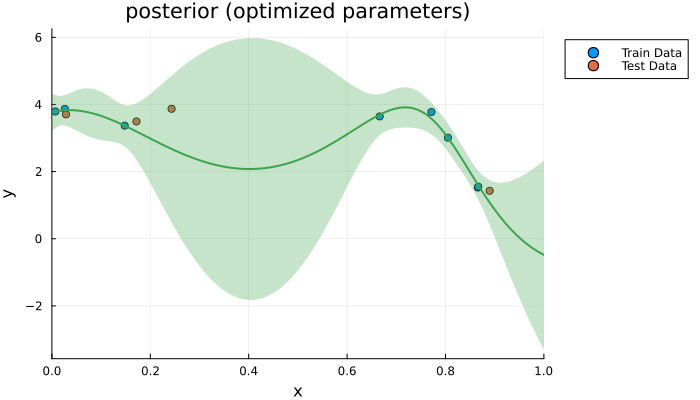

In [1]:
# # Intro to AbstractGPs: one-dimensional regression
#
# ## Setup
#
# Loading the necessary packages.

using AbstractGPs
using Distributions
using FillArrays
using StatsFuns

using Plots
default(; legend=:outertopright, size=(700, 400))

using Random
Random.seed!(42)  # setting the seed for reproducibility of this notebook
#md nothing #hide

# Load toy regression
# [dataset](https://github.com/GPflow/GPflow/blob/7705cee6723f78066981f27954130daaede55dfc/doc/sphinx/notebooks/basics/data/regression_1D.csv)
# taken from GPflow examples.

x = [
    0.8658165855998895,
    0.6661700880180962,
    0.8049218148148531,
    0.7714303440386239,
    0.14790478354654835,
    0.8666105548197428,
    0.007044577166530286,
    0.026331737288148638,
    0.17188596617099916,
    0.8897812990554013,
    0.24323574561119998,
    0.028590102134105955,
]
y = [
    1.5255314337144372,
    3.6434202968230003,
    3.010885733911661,
    3.774442382979625,
    3.3687639483798324,
    1.5506452040608503,
    3.790447985799683,
    3.8689707574953,
    3.4933565751758713,
    1.4284538820635841,
    3.8715350915692364,
    3.7045949061144983,
]
scatter(x, y; xlabel="x", ylabel="y", legend=false)

# We split the observations into train and test data.

x_train = x[1:8]
y_train = y[1:8]
x_test = x[9:end]
y_test = y[9:end]
#md nothing #hide

# We instantiate a Gaussian process with a Matern kernel. The kernel has
# fixed variance and length scale parameters of default value 1.

f = GP(Matern52Kernel())
#md nothing #hide

# We create a finite dimensional projection at the inputs of the training dataset
# observed under Gaussian noise with variance $noise\_var = 0.1$, and compute the
# log-likelihood of the outputs of the training dataset.

noise_var = 0.1
fx = f(x_train, noise_var)
logpdf(fx, y_train)

# We compute the posterior Gaussian process given the training data, and calculate the
# log-likelihood of the test dataset.

p_fx = posterior(fx, y_train)
logpdf(p_fx(x_test, noise_var), y_test)

# We plot the posterior Gaussian process (its mean and a ribbon of 2 standard deviations
# around it) on a grid along with the observations.

scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (default parameters)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, p_fx; label=false, ribbon_scale=2)

# ## Markov Chain Monte Carlo
#
# Previously we computed the log likelihood of the untuned kernel parameters of the GP.
# We now also perform approximate inference over said kernel parameters using different
# Markov chain Monte Carlo (MCMC) methods. I.e., we approximate the posterior distribution
# of the kernel parameters with samples from a Markov chain.
#
# We define a function which returns the log-likelihood of the data for different variance
# and inverse lengthscale parameters of the Matern kernel. We ensure that these parameters are
# positive with the softplus function
# ```math
# f(x) = \log (1 + \exp x).
# ```

function gp_loglikelihood(x, y)
    function loglikelihood(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, noise_var)
        return logpdf(fx, y)
    end
    return loglikelihood
end

const loglik_train = gp_loglikelihood(x_train, y_train)
#md nothing #hide

# We define a Gaussian prior for the joint distribution of the two transformed kernel
# parameters. We assume that both parameters are independent with mean 0 and variance 1.

logprior(params) = logpdf(MvNormal(Eye(2)), params)
#md nothing #hide

# ### Hamiltonian Monte Carlo
#
# We start with a Hamiltonian Monte Carlo (HMC) sampler. More precisely, we use the
# [No-U-Turn sampler (NUTS)](http://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf),
# which is provided by the Julia packages
# [AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl/) and
# [DynamicHMC.jl](https://github.com/tpapp/DynamicHMC.jl/).
#
# #### AdvancedHMC
#
# We start with performing inference with AdvancedHMC.

using AdvancedHMC
using ForwardDiff

# Set the number of samples to draw and warmup iterations.

n_samples = 2_000
n_adapts = 1_000
#md nothing #hide

# AdvancedHMC and DynamicHMC below require us to implement the LogDensityProblems interface for the log joint probability.

using LogDensityProblems

struct LogJointTrain end

## Log joint density
LogDensityProblems.logdensity(::LogJointTrain, θ) = loglik_train(θ) + logprior(θ)

## The parameter space is two-dimensional
LogDensityProblems.dimension(::LogJointTrain) = 2

## `LogJointTrain` does not allow to evaluate derivatives of the log density function
function LogDensityProblems.capabilities(::Type{LogJointTrain})
    return LogDensityProblems.LogDensityOrder{0}()
end
#md nothing #hide

# We use [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) to compute the derivatives of the log joint density with automatic differentiation.

using LogDensityProblemsAD

const logjoint_train = ADgradient(Val(:ForwardDiff), LogJointTrain())
#md nothing #hide

# We define an Hamiltonian system of the log joint probability.

metric = DiagEuclideanMetric(2)
hamiltonian = Hamiltonian(metric, logjoint_train)
#md nothing #hide

# Define a leapfrog solver, with initial step size chosen heuristically.

initial_params = rand(2)
initial_ϵ = find_good_stepsize(hamiltonian, initial_params)
integrator = Leapfrog(initial_ϵ)
#md nothing #hide

# Define an HMC sampler, with the following components:
# - multinomial sampling scheme,
# - generalised No-U-Turn criteria, and
# - windowed adaption for step-size and diagonal mass matrix

proposal = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))
#md nothing #hide

# We draw samples from the posterior distribution of kernel parameters. These samples
# are in the unconstrained space $\mathbb{R}^2$.

samples, _ = sample(
    hamiltonian, proposal, initial_params, n_samples, adaptor, n_adapts; progress=false
)
#md nothing #hide

# We transform the samples back to the constrained space and compute the mean of both
# parameters:

samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

# We plot a histogram of the samples for the two parameters.
# The vertical line in each graph indicates the mean of the samples.

histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
    legend=false,
)
vline!(mean_samples'; linewidth=2)

# We approximate the log-likelihood of the test data using the posterior Gaussian processes
# for kernels with the sampled kernel parameters. We can observe that there is a significant
# improvement over the log-likelihood of the test data with respect to the posterior
# Gaussian process with default kernel parameters of value 1.

function gp_posterior(x, y, p)
    kernel = softplus(p[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(p[2])))
    f = GP(kernel)
    return posterior(f(x, noise_var), y)
end

mean(logpdf(gp_posterior(x_train, y_train, p)(x_test, noise_var), y_test) for p in samples)

# We sample 5 functions from each posterior GP given by the final 100 samples of kernel
# parameters.

plt = plot(; xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (AdvancedHMC)")
for (i, p) in enumerate(samples[(end - 100):end])
    sampleplot!(
        plt,
        0:0.02:1,
        gp_posterior(x_train, y_train, p);
        samples=5,
        seriescolor="red",
        label=(i == 1 ? "samples" : nothing),
    )
end
scatter!(plt, x_train, y_train; label="Train Data", markercolor=1)
scatter!(plt, x_test, y_test; label="Test Data", markercolor=2)
plt

# #### DynamicHMC
#
# We repeat the inference with DynamicHMC.

using DynamicHMC

samples =
    mcmc_with_warmup(
        Random.GLOBAL_RNG, logjoint_train, n_samples; reporter=NoProgressReport()
    ).posterior_matrix
#md nothing #hide

# We transform the samples back to the constrained space and compute the mean of both
# parameters:

samples_constrained = map(softplus, samples)
mean_samples = vec(mean(samples_constrained; dims=2))

# We plot a histogram of the samples for the two parameters.
# The vertical line in each graph indicates the mean of the samples.

histogram(
    samples_constrained';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
    legend=false,
)
vline!(mean_samples'; linewidth=2)

# Again we can observe that there is a significant improvement over the log-likelihood
# of the test data with respect to the posterior Gaussian process with default kernel
# parameters.

mean(logpdf(gp_posterior(x_train, y_train, p)(x_test), y_test) for p in eachcol(samples))

# We sample a function from the posterior GP for the final 100 samples of kernel
# parameters.

plt = plot(; xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (DynamicHMC)")
scatter!(plt, x_train, y_train; label="Train Data")
scatter!(plt, x_test, y_test; label="Test Data")
for i in (n_samples - 100):n_samples
    p = @view samples[:, i]
    sampleplot!(plt, 0:0.02:1, gp_posterior(x_train, y_train, p); seriescolor="red")
end
plt

# ### Elliptical slice sampling
#
# Instead of HMC, we use
# [elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf)
# which is provided by the Julia package
# [EllipticalSliceSampling.jl](https://github.com/TuringLang/EllipticalSliceSampling.jl/).

using EllipticalSliceSampling

# We draw 2000 samples from the posterior distribution of kernel parameters.

samples = sample(ESSModel(
    MvNormal(Eye(2)), # Gaussian prior
    loglik_train,
), ESS(), n_samples; progress=false)
#md nothing #hide

# We transform the samples back to the constrained space and compute the mean of both
# parameters:

samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

# We plot a histogram of the samples for the two parameters.
# The vertical line in each graph indicates the mean of the samples.

histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
)
vline!(mean_samples'; layout=2, labels="mean")

# Again we can observe that there is a significant improvement over the log-likelihood
# of the test data with respect to the posterior Gaussian process with default kernel
# parameters.

mean(logpdf(gp_posterior(x_train, y_train, p)(x_test), y_test) for p in samples)

# We sample a function from the posterior GP for the final 100 samples of kernel
# parameters.

plt = plot(;
    xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (EllipticalSliceSampling)"
)
scatter!(plt, x_train, y_train; label="Train Data")
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end - 100):end]
    sampleplot!(plt, 0:0.02:1, gp_posterior(x_train, y_train, p); seriescolor="red")
end
plt

# ## Variational Inference
#
# Sanity check for the Evidence Lower BOund (ELBO) implemented according to
# M. K. Titsias's _Variational learning of inducing variables in sparse Gaussian processes_.

elbo(VFE(f(rand(5))), fx, y_train)

# We use the LBFGS algorithm to maximize the given ELBO. It is provided by the Julia
# package [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl).

using Optim

# We define a function which returns the negative ELBO for different variance and inverse
# lengthscale parameters of the Matern kernel and different pseudo-points. We ensure that
# the kernel parameters are positive with the softplus function
# ```math
# f(x) = \log (1 + \exp x),
# ```
# and that the pseudo-points are in the unit interval $[0,1]$ with the logistic function
# ```math
# f(x) = \frac{1}{1 + \exp{(-x)}}.
# ```

jitter = 1e-6  # "observing" the latent process with some (small) amount of jitter improves numerical stability

function objective_function(x, y)
    function negative_elbo(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, noise_var)
        z = logistic.(params[3:end])
        approx = VFE(f(z, jitter))
        return -elbo(approx, fx, y)
    end
    return negative_elbo
end
#md nothing #hide

# We randomly initialize the kernel parameters and 5 pseudo points, and minimize the
# negative ELBO with the LBFGS algorithm and obtain the following optimal parameters:

x0 = rand(7)
opt = optimize(objective_function(x_train, y_train), x0, LBFGS())

#-

opt.minimizer

# The optimized value of the variance is

softplus(opt.minimizer[1])

# and of the inverse lengthscale is

softplus(opt.minimizer[2])

# We compute the log-likelihood of the test data for the resulting approximate
# posterior. We can observe that there is a significant improvement over the
# log-likelihood with the default kernel parameters of value 1.

opt_kernel =
    softplus(opt.minimizer[1]) *
    (Matern52Kernel() ∘ ScaleTransform(softplus(opt.minimizer[2])))
opt_f = GP(opt_kernel)
opt_fx = opt_f(x_train, noise_var)
ap = posterior(VFE(opt_f(logistic.(opt.minimizer[3:end]), jitter)), opt_fx, y_train)
logpdf(ap(x_test, noise_var), y_test)

# We visualize the approximate posterior with optimized parameters.

scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (VI with sparse grid)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, ap; label=false, ribbon_scale=2)
vline!(logistic.(opt.minimizer[3:end]); label="Pseudo-points")

# ## Exact Gaussian Process Inference
#
# Here we use Type-II MLE to train the hyperparameters of the Gaussian process.
# This means that our loss function is the negative log marginal likelihood.

# We re-calculate the log-likelihood of the test dataset with the
# default kernel parameters of value 1 for the sake of comparison.

logpdf(p_fx(x_test), y_test)

# We define a function which returns the negative log marginal
# likelihood for different variance and inverse lengthscale parameters
# of the Matern kernel and different pseudo-points. We ensure that the
# kernel parameters are positive with the softplus function
# ``f(x) = \log (1 + \exp x)``.

function loss_function(x, y)
    function negativelogmarginallikelihood(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, noise_var)
        return -logpdf(fx, y)
    end
    return negativelogmarginallikelihood
end

#md nothing #hide

# We randomly initialize the kernel parameters, and minimize the
# negative log marginal likelihood with the LBFGS algorithm
# and obtain the following optimal parameters:

θ0 = randn(2)
opt = Optim.optimize(loss_function(x_train, y_train), θ0, LBFGS())

#-

opt.minimizer

# The optimized value of the variance is

softplus(opt.minimizer[1])

# and of the inverse lengthscale is

softplus(opt.minimizer[2])

# We compute the log-likelihood of the test data for the resulting optimized
# posterior. We can observe that there is a significant improvement over the
# log-likelihood with the default kernel parameters of value 1.

opt_kernel =
    softplus(opt.minimizer[1]) *
    (Matern52Kernel() ∘ ScaleTransform(softplus(opt.minimizer[2])))

opt_f = GP(opt_kernel)
opt_fx = opt_f(x_train, noise_var)
opt_p_fx = posterior(opt_fx, y_train)
logpdf(opt_p_fx(x_test, noise_var), y_test)

# We visualize the posterior with optimized parameters.

scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (optimized parameters)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, opt_p_fx; label=false, ribbon_scale=2)